# Question 4: classification and policy implications

## Define a binary target variable indicating whether a country is likely to reduce its CO2 emissions significantly in the next decade. 

In [1]:
# import dependencies 
import pandas as pd 
import numpy as np 

In [2]:
df = pd.read_csv('../co2_World_Bank.csv')

In [3]:
# preprocessing for defining a threshold

df_wide = df.pivot(index="country", columns="year", values="co2_total").reset_index()
df_wide["reduction_rate"] = (df_wide[2013] - df_wide[2023]) / df_wide[2013]

threshold = df_wide["reduction_rate"].quantile(0.75)  
df_wide["target"] = (df_wide["reduction_rate"] >= threshold).astype(int)

In [4]:
df_aux = df_wide[["country", "reduction_rate", "target"]]

In [5]:
# filter only 2023 registers for the classification model 
df_2023 = df[df['year'] == 2023] 

In [6]:
df_final = df_2023.merge(df_aux, on = 'country', how = "left")
df_final.drop(['reduction_rate', 'year'], axis = 1, inplace= True)
df_final 

,energy_pc,forest_area,gdp,gdp_pc,pop_density,pop_growth_percen,population,food_insecurity,renewables,rural_pop,school_enroll,urban_pop,urban_pop_growth,co2_total,co2_pc,country,target
0,539.542856,4.196650,1.715223e+10,413.757895,74.856948,2.135594,41454761.0,67.741343,45.390635,30289750.0,94.604536,26.933,3.319568,8.707300,0.210043,Afghanistan,0
1,1069.336188,29.559109,2.354718e+10,8575.171346,308.173444,-1.148418,2745972.0,31.249890,15.433907,971992.0,93.713814,64.603,0.103888,4.591800,1.672195,Albania,0
2,1460.081349,0.821279,2.476262e+11,5364.027950,18.712088,1.498976,46164219.0,18.747979,4.496224,11417335.0,108.761642,75.268,2.160135,180.357600,3.906870,Algeria,0
3,5108.787229,30.309584,2.057665e+09,19173.605779,285.413654,-1.712903,47521.0,16.033066,1.396089,6066.0,102.413752,87.235,-1.667363,0.000100,0.002104,American Samoa,0
4,7162.193952,24.942221,3.785067e+09,46812.448449,40.544826,1.433748,80856.0,12.566465,29.591488,9885.0,97.622864,87.774,1.391897,64.037553,10.687351,Andorra,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2982.878357,49.497308,6.075183e+09,29124.721224,384.806733,-0.471641,104917.0,14.570865,5.096143,3959.0,103.607343,96.227,-0.377661,0.000200,0.001906,Virgin Islands (U.S.),0
207,1025.075968,12.344869,1.784790e+10,3455.028529,670.921294,2.393265,5165775.0,31.452215,14.528223,1158063.0,92.084518,77.582,2.769072,2.624544,1.755608,West Bank and Gaza,1
208,128.573186,8.551065,1.858012e+10,426.354076,63.778648,3.009808,39390799.0,55.826687,28.671768,23701050.0,119.507923,39.831,4.637297,10.898800,0.276684,"Yemen, Rep.",1
209,693.577581,52.259741,2.757796e+10,1330.727806,46.850154,2.794068,20723965.0,59.891962,64.626029,11121516.0,109.608933,46.335,4.040607,8.059000,0.388873,Zambia,0


## Train a classification model using the comprehensive set of indicators

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import numpy as np
np.random.seed(42)


# separate predictors from target variable; save id's
ids = df_final["country"]
X = df_final.drop(columns=["country", "target"])
y = df_final["target"]


# train

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.2, random_state=1, stratify=y
)

# rescale predictors and instantiate logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),  
    ('logreg', LogisticRegression(max_iter=1000, class_weight="balanced", random_state=1))  
])

# train the model
pipe.fit(X_train, y_train)

# predictions
# y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

y_pred = (y_proba >= 0.5).astype(int)  

In [8]:

results = pd.DataFrame({
    "country": ids_test,
    "real_target": y_test,
    "pred_target": y_pred,
    "prob_success": y_proba
})

results

,country,real_target,pred_target,prob_success
8,Armenia,0,0,0.427020
205,Viet Nam,0,0,0.330550
165,Sierra Leone,0,0,0.296318
103,Kyrgyz Republic,0,0,0.201128
77,Guinea,0,0,0.154604
185,Tajikistan,0,0,0.150060
179,St. Vincent and the Grenadines,0,0,0.492657
79,Guyana,0,0,0.368410
187,Thailand,0,0,0.411378
148,Papua New Guinea,0,0,0.230638


## Evaluate the classifier's performance using metrics like accuracy, precision, recall, and F1 score. 

In [ ]:
# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        32
           1       0.53      0.82      0.64        11

    accuracy                           0.77        43
   macro avg       0.73      0.78      0.74        43
weighted avg       0.82      0.77      0.78        43



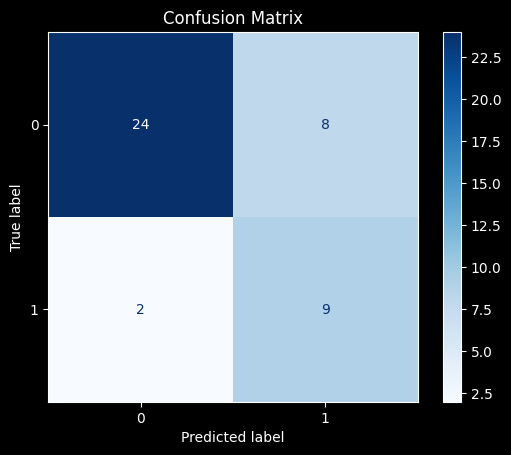

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# confusion  matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


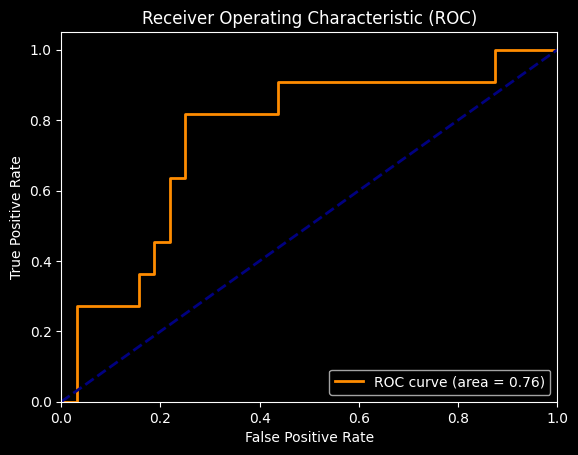

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## Analyze the key features driving the classification

In [16]:
coef = pipe.named_steps['logreg'].coef_[0]
features = X_train.columns
feature_importance = pd.DataFrame({
    "feature": features,
    "coef": coef
}).sort_values(by="coef", ascending=False)

feature_importance

,feature,coef
2,gdp,0.719253
3,gdp_pc,0.669608
11,urban_pop,0.421930
10,school_enroll,0.144390
1,forest_area,0.144079
14,co2_pc,0.101454
6,population,0.052179
12,urban_pop_growth,-0.061623
8,renewables,-0.084823
0,energy_pc,-0.128771


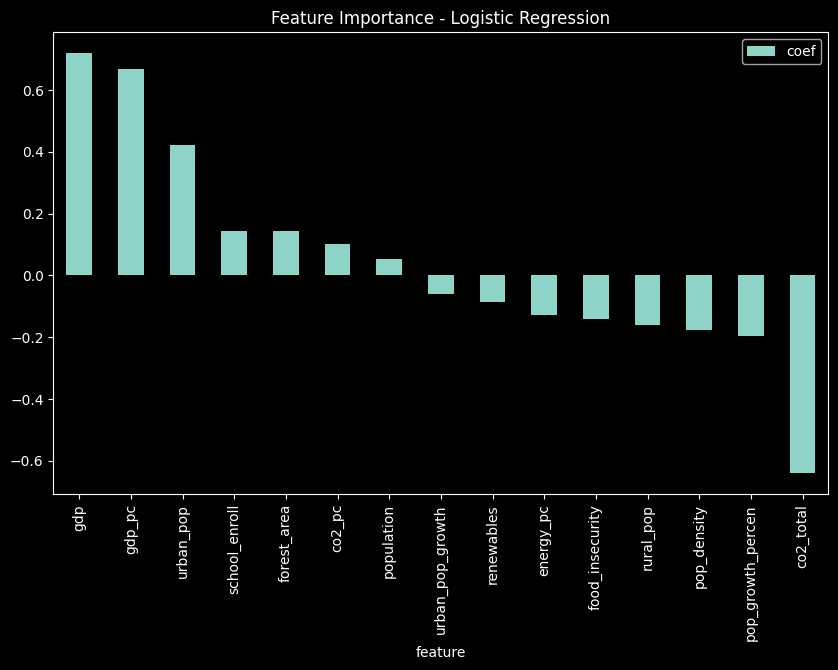

In [15]:
import matplotlib.pyplot as plt
feature_importance.plot.bar(x="feature", y="coef", figsize=(10,6))
plt.title("Feature Importance - Logistic Regression")
plt.show()
